In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import transformers
import evaluate
from datasets import load_dataset
from collections import Counter
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding

%matplotlib inline

In [2]:
dataset = load_dataset("AmazonScience/massive", "pl-PL")

Found cached dataset massive (/home/rj/.cache/huggingface/datasets/AmazonScience___massive/pl-PL/1.0.0/71d360eb7d7a18565ff8c10609cebf714fce3cc390e173ba5b02ffd48543cdc1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [4]:
for subset_name in dataset:
    dataset[subset_name] = dataset[subset_name].remove_columns([
        "locale",
        "scenario",
        "annot_utt",
        "worker_id",
        "slot_method",
        "judgments"
    ])
    dataset[subset_name] = dataset[subset_name].rename_column("intent", "label")
    dataset[subset_name] = dataset[subset_name].rename_column("utt", "text")

In [5]:
dataset["train"]

Dataset({
    features: ['id', 'partition', 'label', 'text'],
    num_rows: 11514
})

In [6]:
dataset["train"][21]

{'id': '33',
 'partition': 'train',
 'label': 32,
 'text': 'sprawdź kiedy zaczyna się przedstawienie'}

In [7]:
print(f"Training data: {len(dataset['train'])} examples; validation: {len(dataset['validation'])} examples; test: {len(dataset['test'])} examples.")

Training data: 11514 examples; validation: 2033 examples; test: 2974 examples.


In [8]:
intent_count = {
    subset_name: Counter(text["label"] for text in dataset[subset_name])
    for subset_name in dataset.keys()
}
intent_count

{'train': Counter({50: 810,
          45: 639,
          13: 573,
          32: 566,
          12: 555,
          49: 544,
          22: 503,
          44: 418,
          33: 354,
          0: 350,
          30: 312,
          36: 283,
          47: 283,
          26: 267,
          42: 227,
          9: 207,
          59: 198,
          58: 193,
          6: 190,
          48: 182,
          21: 177,
          19: 173,
          53: 164,
          57: 154,
          40: 153,
          4: 152,
          20: 150,
          10: 142,
          16: 135,
          23: 130,
          2: 127,
          17: 127,
          1: 125,
          56: 124,
          3: 122,
          11: 117,
          43: 113,
          51: 112,
          46: 110,
          14: 110,
          27: 108,
          54: 100,
          34: 93,
          52: 78,
          39: 78,
          31: 76,
          18: 76,
          25: 72,
          55: 70,
          15: 54,
          38: 52,
          8: 52,
          35: 52,
   

[Text(0.5, 1.0, 'Intent distribution in training data')]

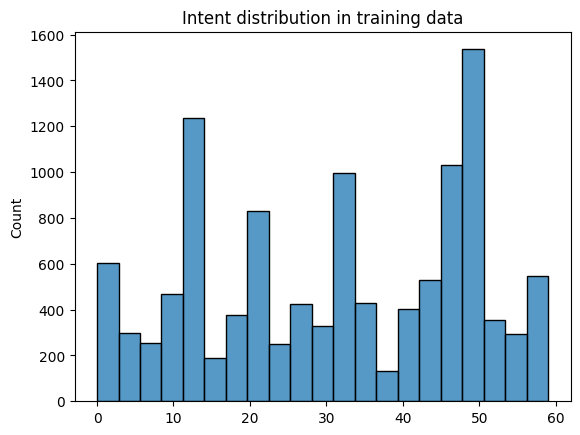

In [9]:
sns.histplot([text["label"] for text in dataset["train"]]).set(title = "Intent distribution in training data")

[Text(0.5, 1.0, 'Intent distribution in validation data')]

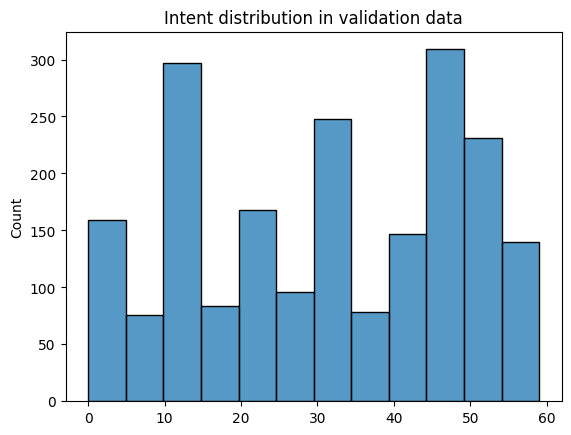

In [10]:
sns.histplot([text["label"] for text in dataset["validation"]]).set(title = "Intent distribution in validation data")

[Text(0.5, 1.0, 'Intent distribution in test data')]

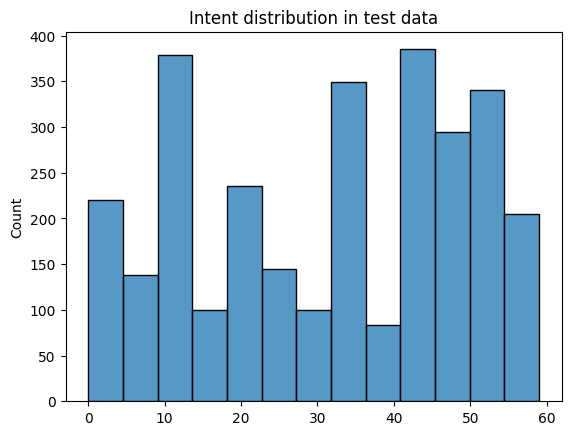

In [11]:
sns.histplot([text["label"] for text in dataset["test"]]).set(title = "Intent distribution in test data")

## Try to run a model for classification

In [12]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-large-cased")

In [20]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [21]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/11514 [00:00<?, ? examples/s]

Map:   0%|          | 0/2033 [00:00<?, ? examples/s]

Map:   0%|          | 0/2974 [00:00<?, ? examples/s]

In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [23]:
accuracy = evaluate.load("accuracy")

In [24]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [25]:
num_labels = len(set(dataset["train"]["label"]))
num_labels

60

In [37]:
class_label = dataset["train"].features["label"]
id2label = {i: label 
            for label, i in zip(
                (class_label.names),
                (class_label.str2int(name) for name in class_label.names))
           }
label2id = {v: k for k, v in id2label.items()}

In [40]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "allegro/herbert-large-cased",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at allegro/herbert-large-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification

In [44]:
training_args = transformers.TrainingArguments(
    output_dir="../resources",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

In [45]:
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [46]:
trainer.train()

/home/rj/envs/intent/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 